# Idaho Data Processing in Jupyter

Digital Globe's Idaho data provides an incredibly powerful multispectral tile service.  In this notebook we demonstrate using it to quickly find and compute changes between time points in WorldView Built-up Index, while retaining the full power of a general analysis and coding environment.

## Imports and general setup


In [13]:
from idaho_map import Map
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import json
import os
import threading
import rasterio
from ipywidgets import widgets
import numpy as np
from gbdxtools import Interface
gbdx = Interface()

## Interactive Data Selection

We've created a couple of open-source libraries (called [jupyter-react](https://github.com/timbr-io/jupyter-react) and [jupyter-react-js](https://github.com/timbr-io/jupyter-react)) to enable integration of full ReactJS user interfaces that can call and respond to python code into the jupyter notebook.  We've also created a simple proof-of-concept REST streaming API for Idaho data called [idaho-streamer](https://github.com/timbr-io/idaho-streamer)  that we've deployed at http://idaho.timbr.io.  Together, these elements allow us to construct a small "live" data collection interface that let's us browse, select, and stich data together that we can further analyze in the notebook.

First we setup the interface:

In [3]:
idaho_map = Map(props={
    'latitude': 8.999,
    'longitude': -79.560,
    'zoom': 10
})

display(idaho_map)

In [5]:
print idaho_map.merged

['/Users/chelm/gbdx/idaho/383d9447-1246-4b9d-82f7-cc4dab35c8f4/merge.tif', '/Users/chelm/gbdx/idaho/2c230734-d222-492c-a9bd-d3d9858b6cd0/merge.tif']


Next we stream data to the map, and select the chips we want to stitch together.  For this demonstration we'll use a historical stream.  We click process once done.

In [4]:
def idaho_stream(config={"fromDate": "2015-01-01"}):
    r = requests.post('http://idaho.timbr.io/filter', json=config, stream=True)
    g = r.iter_lines()
    return g

def start(start, end, bbox=None, delay=None):
    stream = idaho_stream(config={"fromDate": start, "toDate": end, "bbox": bbox, "delay": delay})

    def fn():
        for msg in stream:
            idaho_map.add_features([json.loads(msg)])

    thread = threading.Thread(target=fn)
    thread.start()



start("2016-01-01", "2016-06-01", delay=0.1, bbox="-79.6641801, 8.9214493, -79.46418010000001, 9.1214493")

## Data Preview

Here we use a small code snippet to get a crude visual spectrum preview of the stitched data.

In [6]:
from contextlib import contextmanager

COASTAL = 0
BLUE = 1
GREEN = 2
YELLOW = 3
RED = 4
RED_EDGE = 5
NIR1 = 6
NIR2 = 7

@contextmanager
def load_frame(idx):
    with rasterio.open(idaho_map.merged[idx]) as src:
        bands = src.read([1,2,3,4,5,6,7,8], masked=True).astype(np.float32)
        yield bands

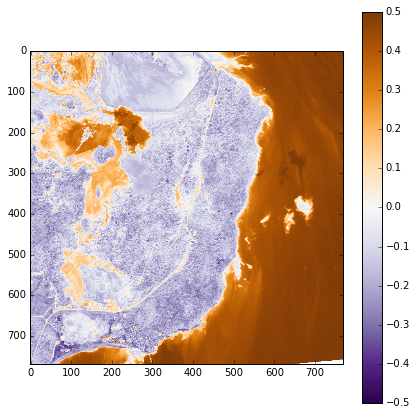

In [7]:
def compute_index(idx):
    with load_frame(idx) as bands:
        # Compute WV-BI Index (Normalized Built-up Index) 
        # http://www.harrisgeospatial.com/docs/BackgroundOtherIndices.html#WorldVie
        return (bands[COASTAL] - bands[RED_EDGE])/(bands[COASTAL] + bands[RED_EDGE])

@widgets.interact(idx=widgets.IntSlider(value=0, min=0, max=len(idaho_map.merged)-1))
def preview_index(idx):
    plt.figure(figsize=(7,7))
    plt.imshow(compute_index(idx), vmin=-0.5, vmax=0.5, cmap="PuOr_r")
    plt.colorbar()
    plt.show()

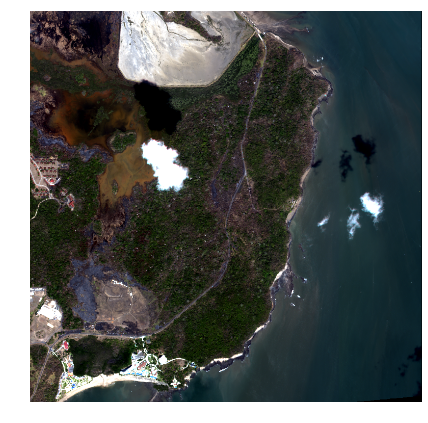

In [8]:
def stretch(rgb):
    lims = np.percentile(rgb,(2,98),axis=(0,1))
    for x in xrange(len(rgb[0,0,:])):
        top = lims[:,x][1]
        bottom = lims[:,x][0]
        rgb[:,:,x] = (rgb[:,:,x]-bottom)/float(top-bottom)
    return np.clip(rgb,0,1)
    
def render(tif, w=7, h=7):
    with rasterio.drivers():
        with rasterio.open(tif) as src:
            b, g, r = src.read([2,3,4], masked=True).astype(np.float32)

    rgb = stretch(np.dstack([r,g,b]))
    plt.figure(figsize=(w,h))
    plt.axis('off')
    plt.grid('off')
    plt.imshow(rgb)
    plt.show() 

@widgets.interact(idx=widgets.IntSlider(value=0, min=0, max=len(idaho_map.merged)-1))
def show_frame(idx):
    render(idaho_map.merged[idx])

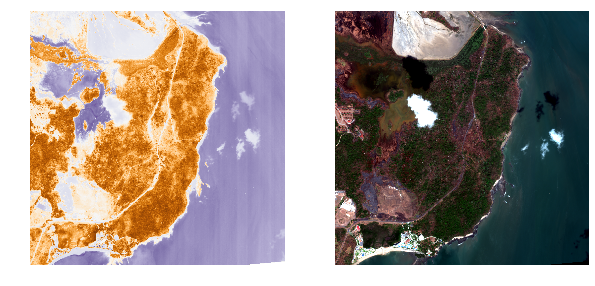

In [14]:
def create_index(tif_path, index_type):
 
    def _calculate(NIR, Red, SWIR=None, Green=None):
        if index_type == 'NDVI':
            return (NIR - Red)/(NIR + Red)
        elif index_type == 'NDWI':
            return (Green - NIR)/(Green + NIR)
        elif index_type == 'NBR':
            return  (NIR - SWIR)/(NIR + SWIR)
        else: # SAVI
            return ((NIR - Red)/(NIR + Red + 0.5)) * (1 + 0.5)
    
    with rasterio.drivers():
        with rasterio.open(tif_path) as src:
           b, g, r, nir = src.read([2,3,5,7], masked=True).astype(np.float32)
        
    index = _calculate(nir, r, Green=g) 
    rgb = stretch(np.dstack([r,g,b]))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10), facecolor='white')
    ax1.axis('off')
    ax2.axis('off')
    ax1.imshow(index, cmap="PuOr_r")
    ax2.imshow(rgb)
    plt.show() 

create_index(idaho_map.merged[0], 'NDVI')